#Considering the fact that using PCA will lower the interpretability of data,so, we use the regular ways of dimensionality reduction instead of using  the PCA first.

In [47]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [48]:
data=pd.read_csv("CollegeScorecard.csv")

C:\Users\derek\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (7,9,1427,1542,1561,1575,1725,1726,1727,1728) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [49]:
data.shape

(7804, 1729)

In [50]:
data.head()

,UNITID,OPEID,opeid6,INSTNM,CITY,STABBR,ZIP,AccredAgency,INSTURL,NPCURL,...,PELL_RPY_3YR_RT_SUPP,NOPELL_RPY_3YR_RT_SUPP,FEMALE_RPY_3YR_RT_SUPP,MALE_RPY_3YR_RT_SUPP,FIRSTGEN_RPY_3YR_RT_SUPP,NOTFIRSTGEN_RPY_3YR_RT_SUPP,C150_L4_POOLED_SUPP,C150_4_POOLED_SUPP,C200_L4_POOLED_SUPP,C200_4_POOLED_SUPP
0,100654,100200,1002,Alabama A & M University,Normal,AL,35762,Southern Association of Colleges and Schools C...,www.aamu.edu/,galileo.aamu.edu/netpricecalculator/npcalc.htm,...,0.443586698337,0.45251396648,0.484818805093,0.406,0.423580786026,0.442452830189,NaN,0.30871831265508,NaN,0.35168556430446
1,100663,105200,1052,University of Alabama at Birmingham,Birmingham,AL,35294-0110,Southern Association of Colleges and Schools C...,www.uab.edu,www.collegeportraits.org/AL/UAB/estimator/agree,...,0.732297852901,0.795454545455,0.760521885522,0.755344418052,0.751552795031,0.765074770863,NaN,0.50854980789381,NaN,0.4730923834537
2,100690,2503400,25034,Amridge University,Montgomery,AL,36117-3553,Southern Association of Colleges and Schools C...,www.amridgeuniversity.edu,tcc.noellevitz.com/(S(miwoihs5stz5cpyifh4nczu0...,...,0.600877192982,0.775,0.610465116279,0.686567164179,0.632653061224,0.65,NaN,PrivacySuppressed,NaN,PrivacySuppressed
3,100706,105500,1055,University of Alabama in Huntsville,Huntsville,AL,35899,Southern Association of Colleges and Schools C...,www.uah.edu,finaid.uah.edu/,...,0.738341968912,0.85140562249,0.768378650554,0.798440979955,0.778156996587,0.791666666667,NaN,0.47821134615384,NaN,0.49412939796716
4,100724,100500,1005,Alabama State University,Montgomery,AL,36104-0271,Southern Association of Colleges and Schools C...,www.alasu.edu/email/index.aspx,www.alasu.edu/cost-aid/forms/calculator/index....,...,0.320016820858,0.380829015544,0.364423717522,0.286530612245,0.315737051793,0.334633385335,NaN,0.25748195545488,NaN,0.29365162671232


### Data cleaning

In [51]:
#Replace all PrivacySuppressed with NAN
data.replace("PrivacySuppressed",np.nan,inplace=True)

In [52]:
#Checking the percentage of missing data in each value
((data.isnull().sum())/data.shape[0]).sort_values(ascending=False).map(lambda x:"{:.2%}".format(x))

DEP_ENRL_ORIG_YR4_RT             100.00%
LO_INC_COMP_ORIG_YR4_RT          100.00%
LO_INC_ENRL_4YR_TRANS_YR4_RT     100.00%
LO_INC_ENRL_ORIG_YR4_RT          100.00%
LO_INC_WDRAW_2YR_TRANS_YR4_RT    100.00%
                                  ...   
CONTROL                            0.00%
st_fips                            0.00%
region                             0.00%
CURROPER                           0.00%
UNITID                             0.00%
Length: 1729, dtype: object

In [53]:
#From the percentage of missing data,there are parts that contain data that was 100% missing, so we want to delete all of these columns
#For the rows of data that are fully missing, they are deleted too because they do not need to be clustered
data.dropna(axis=0, how='all', thresh=None, subset=None, inplace=True)
data.dropna(axis=1, how='all', thresh=None, subset=None, inplace=True)

In [54]:
#From the data above, there was 1174 columns that was deleted and no rows were deleted.
data.shape

(7804, 555)

In [55]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7804 entries, 0 to 7803
Columns: 555 entries, UNITID to C200_4_POOLED_SUPP
dtypes: float64(365), int64(12), object(178)
memory usage: 33.1+ MB


In [56]:
# Further processing for missing data
ls_keys=((data.isnull().sum())/data.shape[0]).sort_values(ascending=False).keys()#Select the name of the missing data
list_values=list(((data.isnull().sum())/data.shape[0]).sort_values(ascending=False).values)#Select the percentage of columns with the missing data

In [57]:
null_pd=pd.DataFrame({"columns":ls_keys,'Percentage of vacant values':list_values})

In [58]:
null_pd.head()

,columns,Percentage of vacant values
0,ACTWRMID,0.961558
1,ACTWR25,0.961558
2,ACTWR75,0.961558
3,C150_4_NHPI,0.949769
4,C150_L4_NRA,0.921194


In [59]:
#Keep the data that has a percentage of missing data lower than 60%
null_ls=list(null_pd[null_pd['Percentage of vacant values']>0.6]['columns'])

In [60]:
#Delete the columns that contains more than 60% of the missing data
for i in null_ls:
    data.drop(i,axis=1,inplace=True)

In [61]:
data.shape

(7804, 456)

In [62]:
#observing the data under the object type
obj_col_ls=list(data.select_dtypes(include=['object']).columns)

In [63]:
data[obj_col_ls].head()

,INSTNM,CITY,STABBR,ZIP,AccredAgency,INSTURL,NPCURL,RPY_3YR_RT,LO_INC_RPY_3YR_RT,MD_INC_RPY_3YR_RT,...,DEP_RPY_3YR_RT_SUPP,IND_RPY_3YR_RT_SUPP,PELL_RPY_3YR_RT_SUPP,NOPELL_RPY_3YR_RT_SUPP,FEMALE_RPY_3YR_RT_SUPP,MALE_RPY_3YR_RT_SUPP,FIRSTGEN_RPY_3YR_RT_SUPP,NOTFIRSTGEN_RPY_3YR_RT_SUPP,C150_L4_POOLED_SUPP,C200_L4_POOLED_SUPP
0,Alabama A & M University,Normal,AL,35762,Southern Association of Colleges and Schools C...,www.aamu.edu/,galileo.aamu.edu/netpricecalculator/npcalc.htm,0.444713870029,0.448163265306,0.446488294314,...,0.442857142857,0.458904109589,0.443586698337,0.45251396648,0.484818805093,0.406,0.423580786026,0.442452830189,NaN,NaN
1,University of Alabama at Birmingham,Birmingham,AL,35294-0110,Southern Association of Colleges and Schools C...,www.uab.edu,www.collegeportraits.org/AL/UAB/estimator/agree,0.756266666667,0.724256292906,0.770134228188,...,0.767798013245,0.739164696612,0.732297852901,0.795454545455,0.760521885522,0.755344418052,0.751552795031,0.765074770863,NaN,NaN
2,Amridge University,Montgomery,AL,36117-3553,Southern Association of Colleges and Schools C...,www.amridgeuniversity.edu,tcc.noellevitz.com/(S(miwoihs5stz5cpyifh4nczu0...,0.647249190939,0.597701149425,NaN,...,NaN,0.641114982578,0.600877192982,0.775,0.610465116279,0.686567164179,0.632653061224,0.65,NaN,NaN
3,University of Alabama in Huntsville,Huntsville,AL,35899,Southern Association of Colleges and Schools C...,www.uah.edu,finaid.uah.edu/,0.781997918835,0.721404303511,0.824742268041,...,0.800347222222,0.755644090305,0.738341968912,0.85140562249,0.768378650554,0.798440979955,0.778156996587,0.791666666667,NaN,NaN
4,Alabama State University,Montgomery,AL,36104-0271,Southern Association of Colleges and Schools C...,www.alasu.edu/email/index.aspx,www.alasu.edu/cost-aid/forms/calculator/index....,0.331198861615,0.310875331565,0.37610619469,...,0.324102120294,0.350993377483,0.320016820858,0.380829015544,0.364423717522,0.286530612245,0.315737051793,0.334633385335,NaN,NaN


###Because PrivacySuppressed exist, there are many float types but determined as objects

In [64]:
real_object=[]
for i in obj_col_ls:
    try:
        data[i]=data[i].astype("float")
    except:
        real_object.append(i)

In [65]:
real_object

['INSTNM', 'CITY', 'STABBR', 'ZIP', 'AccredAgency', 'INSTURL', 'NPCURL']

In [66]:
data[real_object].head()

,INSTNM,CITY,STABBR,ZIP,AccredAgency,INSTURL,NPCURL
0,Alabama A & M University,Normal,AL,35762,Southern Association of Colleges and Schools C...,www.aamu.edu/,galileo.aamu.edu/netpricecalculator/npcalc.htm
1,University of Alabama at Birmingham,Birmingham,AL,35294-0110,Southern Association of Colleges and Schools C...,www.uab.edu,www.collegeportraits.org/AL/UAB/estimator/agree
2,Amridge University,Montgomery,AL,36117-3553,Southern Association of Colleges and Schools C...,www.amridgeuniversity.edu,tcc.noellevitz.com/(S(miwoihs5stz5cpyifh4nczu0...
3,University of Alabama in Huntsville,Huntsville,AL,35899,Southern Association of Colleges and Schools C...,www.uah.edu,finaid.uah.edu/
4,Alabama State University,Montgomery,AL,36104-0271,Southern Association of Colleges and Schools C...,www.alasu.edu/email/index.aspx,www.alasu.edu/cost-aid/forms/calculator/index....


In [67]:
for i in real_object:
    data.drop(i,axis=1,inplace=True)

In [68]:
data.head()

,UNITID,OPEID,opeid6,HCM2,main,NUMBRANCH,PREDDEG,HIGHDEG,CONTROL,st_fips,...,DEP_RPY_3YR_RT_SUPP,IND_RPY_3YR_RT_SUPP,PELL_RPY_3YR_RT_SUPP,NOPELL_RPY_3YR_RT_SUPP,FEMALE_RPY_3YR_RT_SUPP,MALE_RPY_3YR_RT_SUPP,FIRSTGEN_RPY_3YR_RT_SUPP,NOTFIRSTGEN_RPY_3YR_RT_SUPP,C150_L4_POOLED_SUPP,C200_L4_POOLED_SUPP
0,100654,100200,1002,0,1,1,3,4,1,1,...,0.442857,0.458904,0.443587,0.452514,0.484819,0.406000,0.423581,0.442453,NaN,NaN
1,100663,105200,1052,0,1,1,3,4,1,1,...,0.767798,0.739165,0.732298,0.795455,0.760522,0.755344,0.751553,0.765075,NaN,NaN
2,100690,2503400,25034,0,1,1,3,4,2,1,...,NaN,0.641115,0.600877,0.775000,0.610465,0.686567,0.632653,0.650000,NaN,NaN
3,100706,105500,1055,0,1,1,3,4,1,1,...,0.800347,0.755644,0.738342,0.851406,0.768379,0.798441,0.778157,0.791667,NaN,NaN
4,100724,100500,1005,0,1,1,3,4,1,1,...,0.324102,0.350993,0.320017,0.380829,0.364424,0.286531,0.315737,0.334633,NaN,NaN


In [69]:
#select the id
data_id=data['UNITID']

In [70]:
#select the features
data_info=data.drop('UNITID',axis=1)

In [71]:
data_info.shape

(7804, 448)

In [72]:
X=data_info

In [73]:
#use the mean to fill in the missing data
for i in X:
    X[i] = X[i].fillna(X[i].mean())

#use the Silhouette Coefficient as Evaluation Criteria

In [74]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7804 entries, 0 to 7803
Columns: 448 entries, OPEID to C200_L4_POOLED_SUPP
dtypes: float64(437), int64(11)
memory usage: 26.7 MB


In [75]:
X.head()

,OPEID,opeid6,HCM2,main,NUMBRANCH,PREDDEG,HIGHDEG,CONTROL,st_fips,region,...,DEP_RPY_3YR_RT_SUPP,IND_RPY_3YR_RT_SUPP,PELL_RPY_3YR_RT_SUPP,NOPELL_RPY_3YR_RT_SUPP,FEMALE_RPY_3YR_RT_SUPP,MALE_RPY_3YR_RT_SUPP,FIRSTGEN_RPY_3YR_RT_SUPP,NOTFIRSTGEN_RPY_3YR_RT_SUPP,C150_L4_POOLED_SUPP,C200_L4_POOLED_SUPP
0,100200,1002,0,1,1,3,4,1,1,5,...,0.442857,0.458904,0.443587,0.452514,0.484819,0.406000,0.423581,0.442453,0.555786,0.587888
1,105200,1052,0,1,1,3,4,1,1,5,...,0.767798,0.739165,0.732298,0.795455,0.760522,0.755344,0.751553,0.765075,0.555786,0.587888
2,2503400,25034,0,1,1,3,4,2,1,5,...,0.637070,0.641115,0.600877,0.775000,0.610465,0.686567,0.632653,0.650000,0.555786,0.587888
3,105500,1055,0,1,1,3,4,1,1,5,...,0.800347,0.755644,0.738342,0.851406,0.768379,0.798441,0.778157,0.791667,0.555786,0.587888
4,100500,1005,0,1,1,3,4,1,1,5,...,0.324102,0.350993,0.320017,0.380829,0.364424,0.286531,0.315737,0.334633,0.555786,0.587888


### Use K-means for modeling

In [76]:
#Based on the Silhouette Coefficient,select the best choice, n_cluster

For n_clusters = 2 The average silhouette_score is : 0.9574524526615807


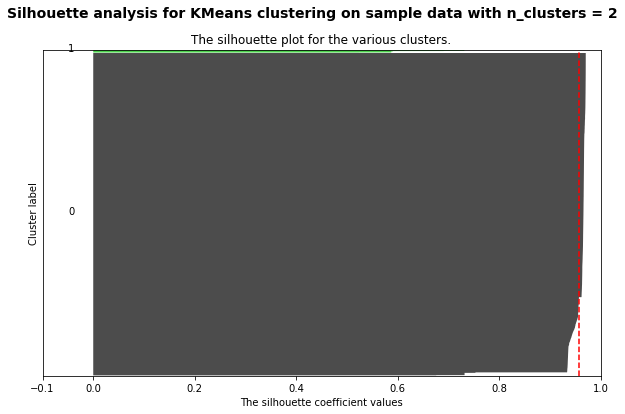

For n_clusters = 3 The average silhouette_score is : 0.7110851904213422


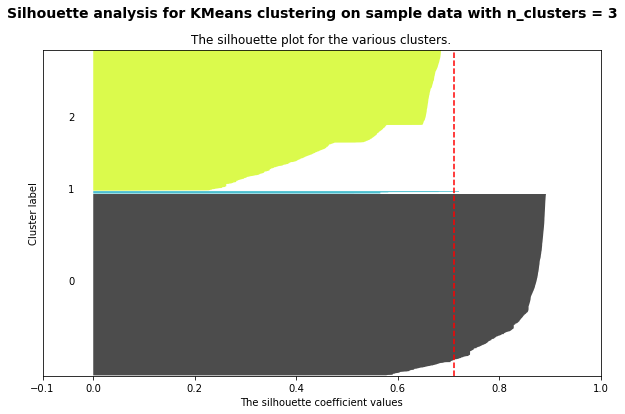

For n_clusters = 4 The average silhouette_score is : 0.7129055089406346


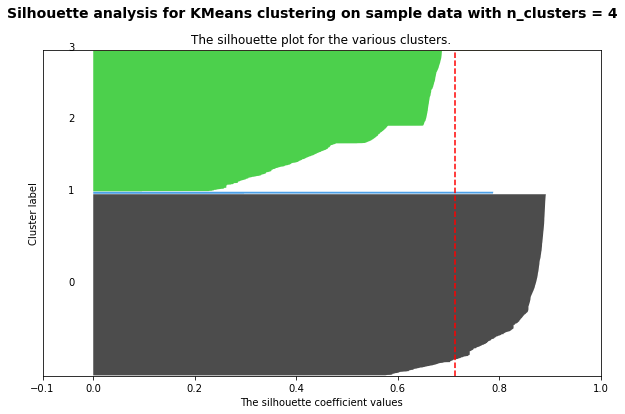

For n_clusters = 5 The average silhouette_score is : 0.7401339554488625


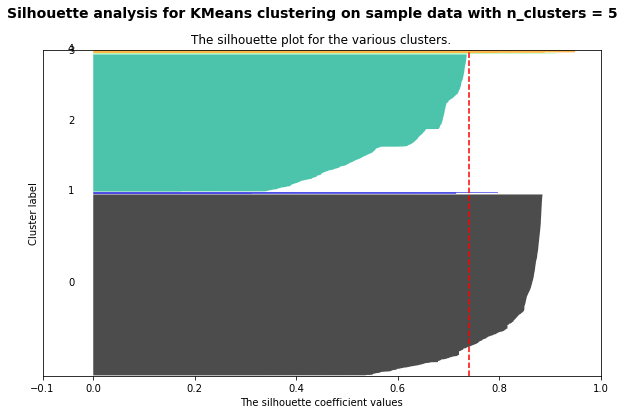

For n_clusters = 6 The average silhouette_score is : 0.7412136597929997


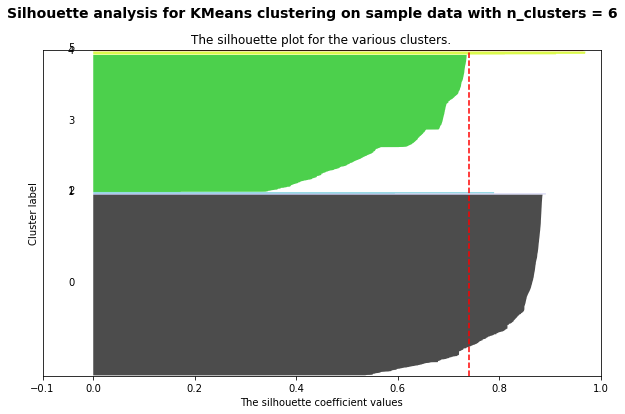

For n_clusters = 7 The average silhouette_score is : 0.731753068480642


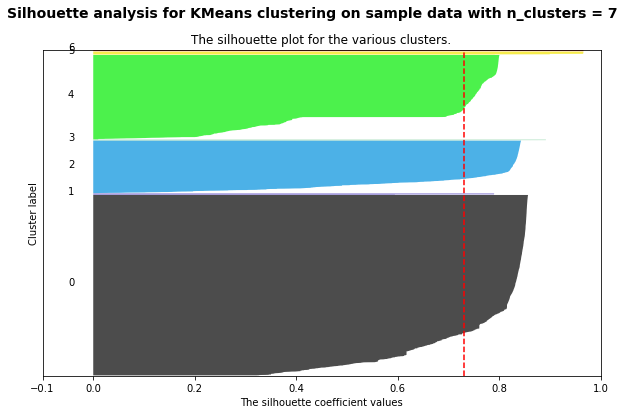

For n_clusters = 8 The average silhouette_score is : 0.6783740528374161


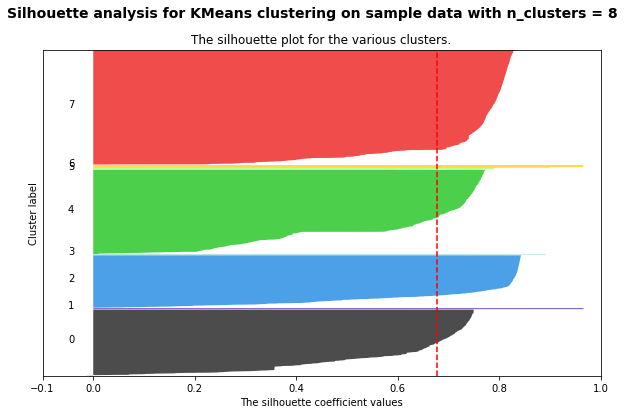

For n_clusters = 9 The average silhouette_score is : 0.6789216298697764


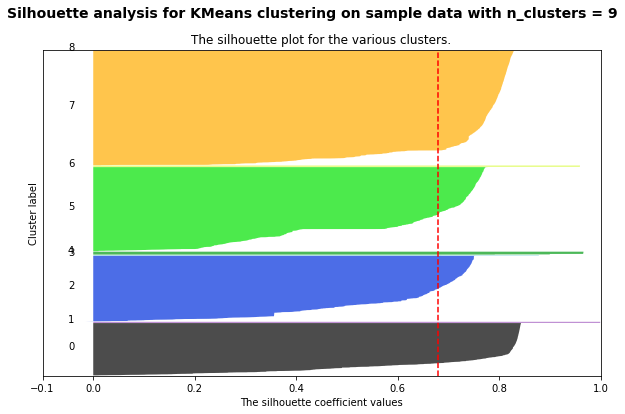

For n_clusters = 10 The average silhouette_score is : 0.7136715602022904


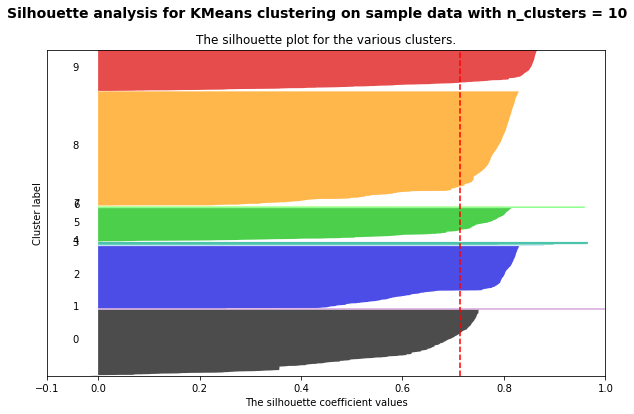

For n_clusters = 11 The average silhouette_score is : 0.7138527747883938


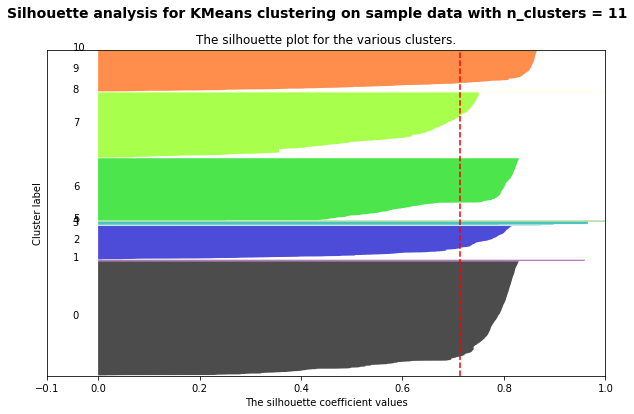

For n_clusters = 12 The average silhouette_score is : 0.7139649559211592


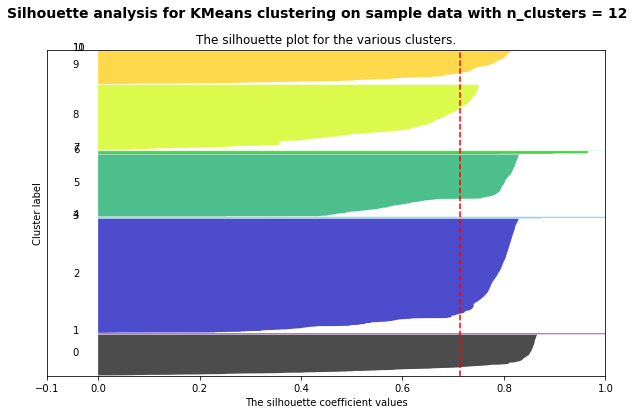

For n_clusters = 13 The average silhouette_score is : 0.7140929873359753


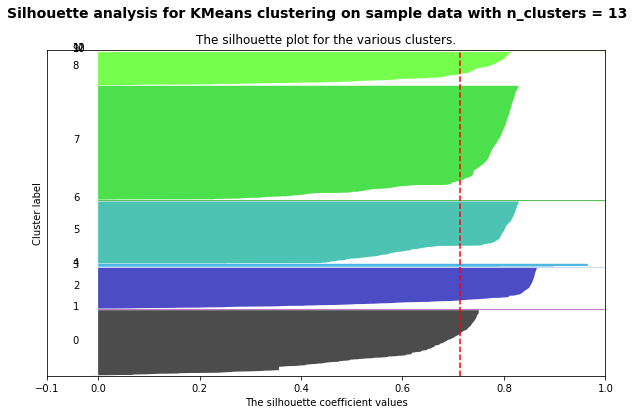

For n_clusters = 14 The average silhouette_score is : 0.6560286925279261


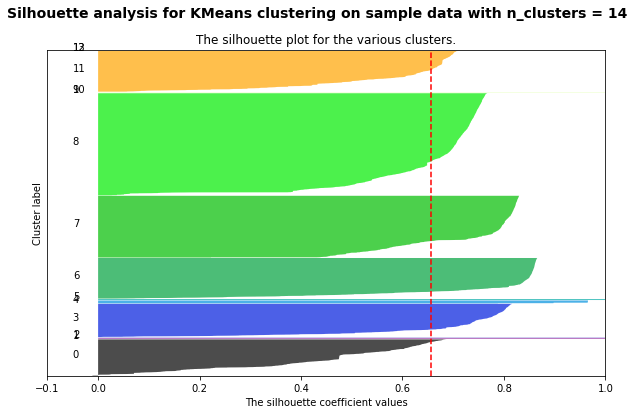

For n_clusters = 15 The average silhouette_score is : 0.6372638247736221


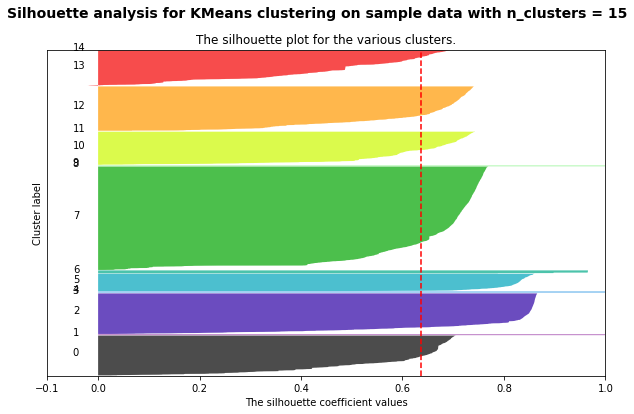

For n_clusters = 16 The average silhouette_score is : 0.6363554937822775


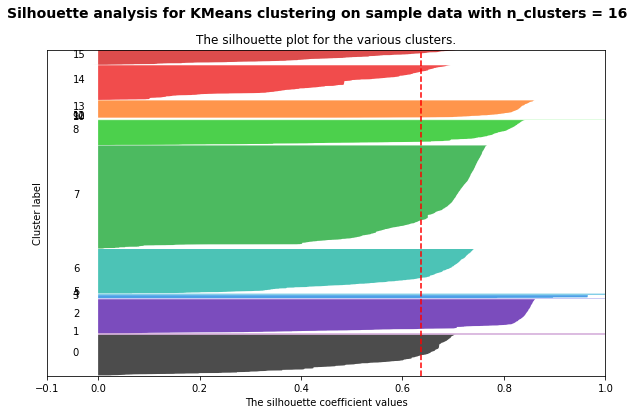

For n_clusters = 17 The average silhouette_score is : 0.566715538712206


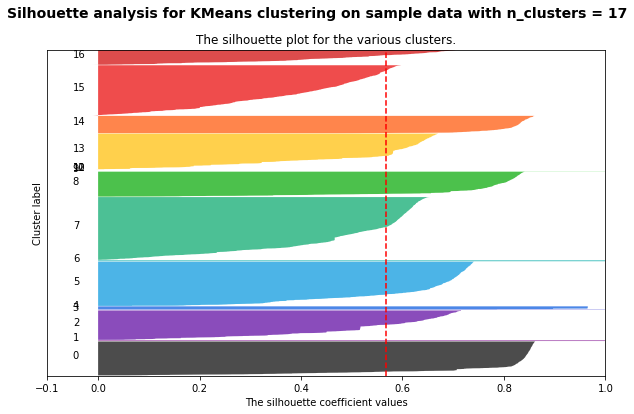

For n_clusters = 18 The average silhouette_score is : 0.5663942152248449


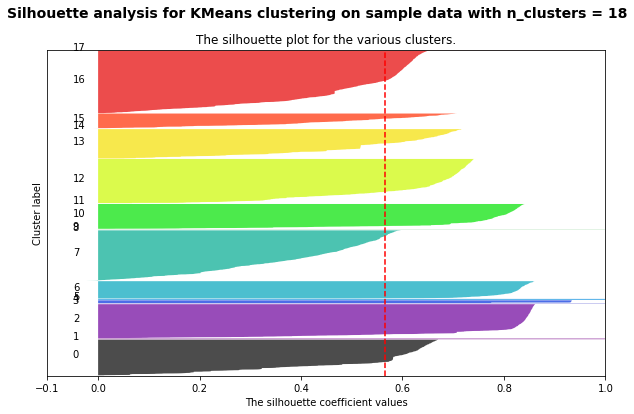

For n_clusters = 19 The average silhouette_score is : 0.561563886404712


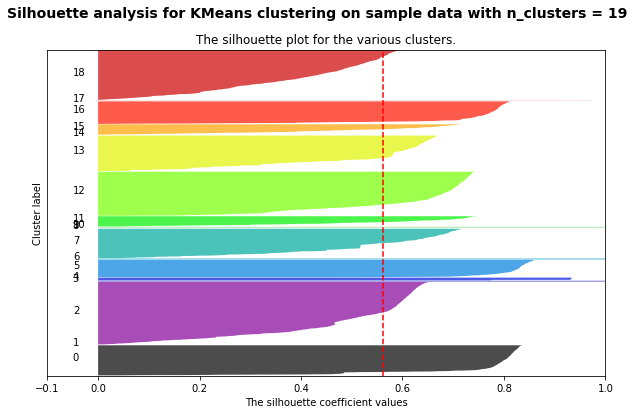

In [77]:
 from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
#From 2-8 clusters were tested separately, and the silhouette_score score and silhouette plot were used as the judgment

for n_clusters in range(2,20):
    n_clusters = n_clusters
    fig,(ax1) = plt.subplots(1, 1)
    fig.set_size_inches(10, 6)
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, X.shape[0] + (n_clusters + 1) * 10])
    clusterer = KMeans(n_clusters=n_clusters, random_state=10).fit(X)
    #cluster_labels as classification resluts
    cluster_labels = clusterer.labels_
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)
    sample_silhouette_values = silhouette_samples(X, cluster_labels)
    y_lower = 10
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        color = cm.nipy_spectral(float(i)/n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper)
                          ,ith_cluster_silhouette_values
                          ,facecolor=color
                          ,alpha=0.7
                         )
        ax1.text(-0.05
                 , y_lower + 0.5 * size_cluster_i
                 , str(i))
        y_lower = y_upper + 10

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
    ax1.set_yticks([])
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')
    plt.show()

### Conclusion

The silhouette_score shows an increasing trend when the cluster is less than 6, but the silhouette_score is mainly contributed by a single classification. The model effect is not good and cannot be selected.
The average silhouette_score is : 0.731873951532229 when n_clusters = 7, reaching the maximum value. And at this time the silhouette_score is contributed by each category and the model works best, so n_clusters = 7 is chosen for modeling

In [78]:
random = KMeans(n_clusters = 7).fit(X)

In [79]:
data_id.values

array([  100654,   100663,   100690, ..., 48285705, 48285706, 48285707],
      dtype=int64)

In [80]:
y_pred_max10 = random.labels_

In [81]:
result=pd.DataFrame({"UNITID":data_id,"result":y_pred_max10})

In [82]:
result.to_excel("result.xlsx")

## 2.Use PCA 

In [83]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [84]:
new_data=pd.DataFrame(data_id)

In [85]:
X.head()

,OPEID,opeid6,HCM2,main,NUMBRANCH,PREDDEG,HIGHDEG,CONTROL,st_fips,region,...,DEP_RPY_3YR_RT_SUPP,IND_RPY_3YR_RT_SUPP,PELL_RPY_3YR_RT_SUPP,NOPELL_RPY_3YR_RT_SUPP,FEMALE_RPY_3YR_RT_SUPP,MALE_RPY_3YR_RT_SUPP,FIRSTGEN_RPY_3YR_RT_SUPP,NOTFIRSTGEN_RPY_3YR_RT_SUPP,C150_L4_POOLED_SUPP,C200_L4_POOLED_SUPP
0,100200,1002,0,1,1,3,4,1,1,5,...,0.442857,0.458904,0.443587,0.452514,0.484819,0.406000,0.423581,0.442453,0.555786,0.587888
1,105200,1052,0,1,1,3,4,1,1,5,...,0.767798,0.739165,0.732298,0.795455,0.760522,0.755344,0.751553,0.765075,0.555786,0.587888
2,2503400,25034,0,1,1,3,4,2,1,5,...,0.637070,0.641115,0.600877,0.775000,0.610465,0.686567,0.632653,0.650000,0.555786,0.587888
3,105500,1055,0,1,1,3,4,1,1,5,...,0.800347,0.755644,0.738342,0.851406,0.768379,0.798441,0.778157,0.791667,0.555786,0.587888
4,100500,1005,0,1,1,3,4,1,1,5,...,0.324102,0.350993,0.320017,0.380829,0.364424,0.286531,0.315737,0.334633,0.555786,0.587888


#Reduce dimensions using PCA

In [86]:
pca = PCA(n_components=2)           
pca = pca.fit(X)                    
X_dr = pca.transform(X)             

In [87]:
pd.DataFrame(X_dr)[0]

0      -1.932246e+06
1      -1.927115e+06
2       4.702865e+05
3      -1.927017e+06
4      -1.931871e+06
            ...     
7799   -1.875171e+06
7800   -1.875177e+06
7801   -1.875173e+06
7802   -1.875178e+06
7803   -1.875175e+06
Name: 0, Length: 7804, dtype: float64

In [88]:
new_data['x1']=pd.DataFrame(X_dr)[0]

In [89]:
new_data['x2']=pd.DataFrame(X_dr)[1]

In [90]:
new_data

,UNITID,x1,x2
0,100654,-1.932246e+06,25825.751268
1,100663,-1.927115e+06,31526.749605
2,100690,4.702865e+05,-37405.260324
3,100706,-1.927017e+06,22371.087202
4,100724,-1.931871e+06,27991.057047
...,...,...,...
7799,48285703,-1.875171e+06,26244.457440
7800,48285704,-1.875177e+06,26240.759312
7801,48285705,-1.875173e+06,26240.205749
7802,48285706,-1.875178e+06,26246.982300


In [91]:
new_data=new_data[new_data['x1']<=new_data['x1'].quantile(q=0.99)]

In [92]:
new_data=new_data[new_data['x1']>=new_data['x1'].quantile(q=0.01)]

In [93]:
new_data=new_data[new_data['x2']<=new_data['x2'].quantile(q=0.99)]

In [94]:
new_data=new_data[new_data['x2']>=new_data['x2'].quantile(q=0.001)]

In [95]:
new_data.reset_index(drop=True,inplace=True)

In [96]:
new_data

,UNITID,x1,x2
0,100690,4.702865e+05,-37405.260324
1,100830,-1.201646e+06,4816.202693
2,101028,-8.146467e+05,-14776.208190
3,101073,-9.772247e+05,-823.130439
4,101116,-7.272324e+05,68743.901631
...,...,...,...
7557,48285703,-1.875171e+06,26244.457440
7558,48285704,-1.875177e+06,26240.759312
7559,48285705,-1.875173e+06,26240.205749
7560,48285706,-1.875178e+06,26246.982300


In [97]:
X=new_data[['x1','x2']]

In [98]:
from sklearn import preprocessing
# Use MinMaxScaler
m_scaler = preprocessing.MinMaxScaler()
m_data = m_scaler.fit_transform(X_dr)

In [99]:
X=m_data

In [100]:
pd.DataFrame(X)

,0,1
0,0.000000,0.343538
1,0.000063,0.346880
2,0.029297,0.306476
3,0.000064,0.341513
4,0.000005,0.344807
...,...,...
7799,0.000696,0.343783
7800,0.000696,0.343781
7801,0.000696,0.343781
7802,0.000696,0.343785


For n_clusters = 2 The average silhouette_score is : 0.9325882174307325


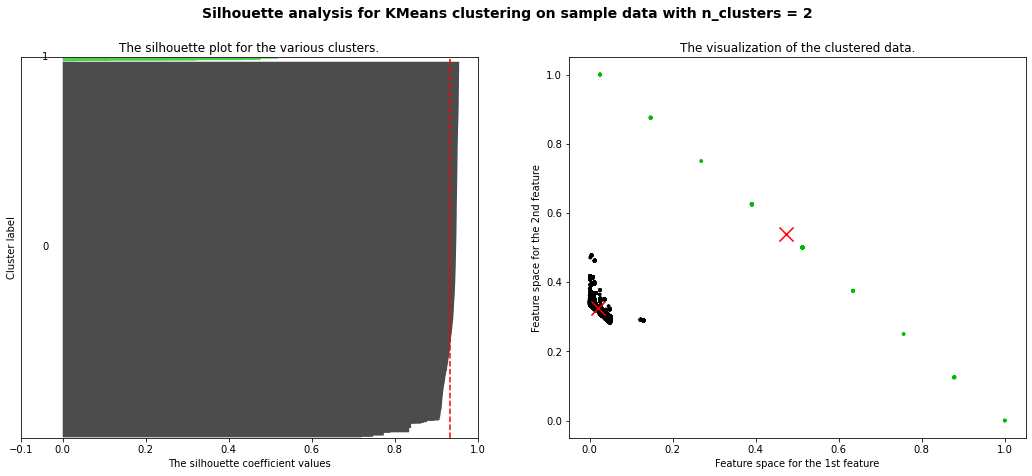

For n_clusters = 3 The average silhouette_score is : 0.6094431526779835


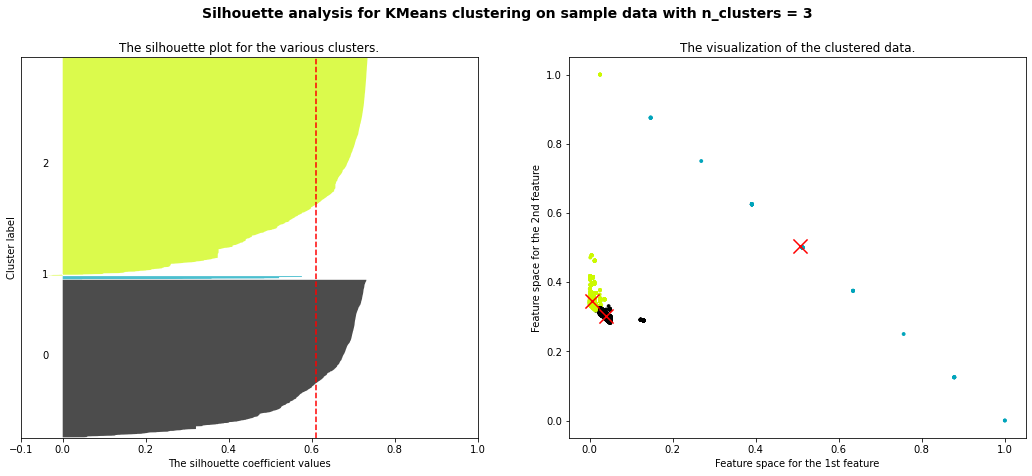

For n_clusters = 4 The average silhouette_score is : 0.6165334555947868


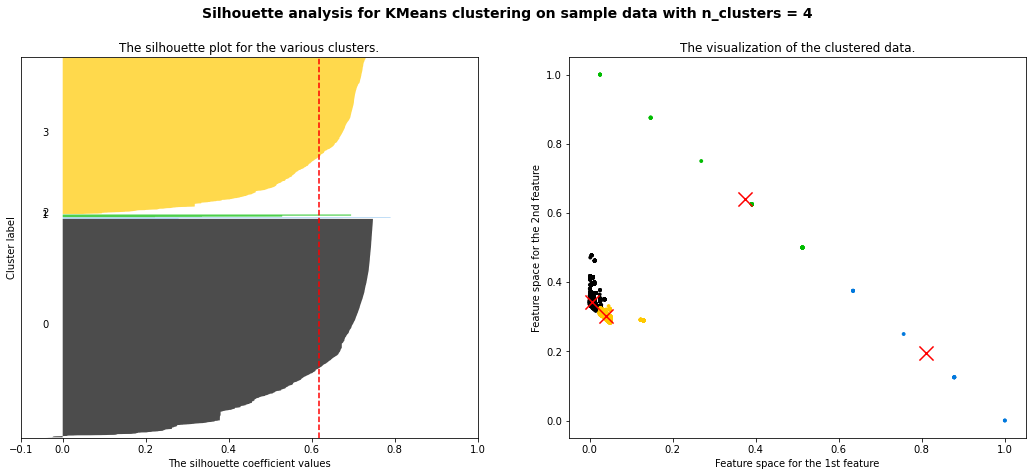

For n_clusters = 5 The average silhouette_score is : 0.6180722760210541


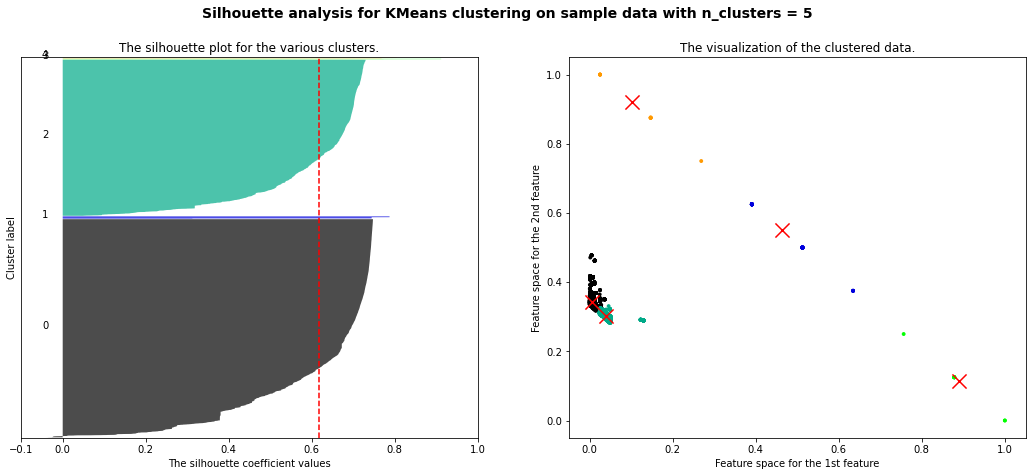

For n_clusters = 6 The average silhouette_score is : 0.6576940621629036


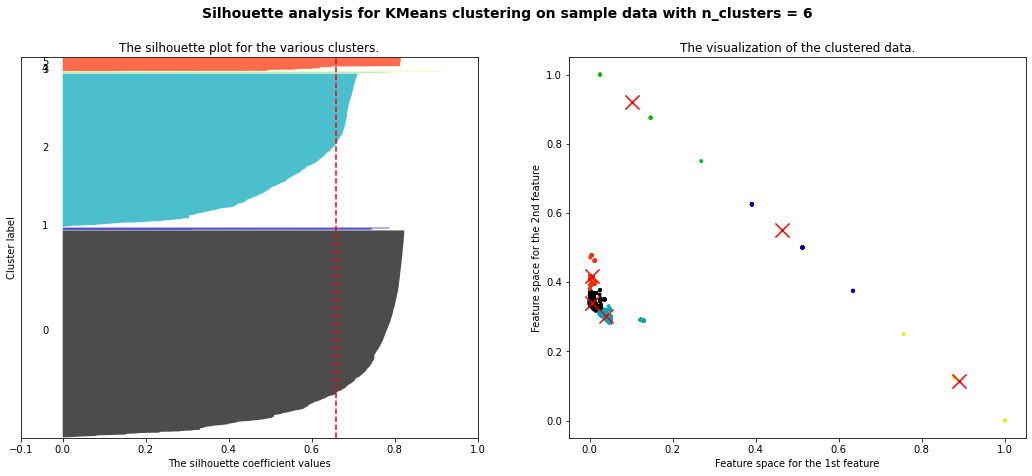

For n_clusters = 7 The average silhouette_score is : 0.5986641304898696


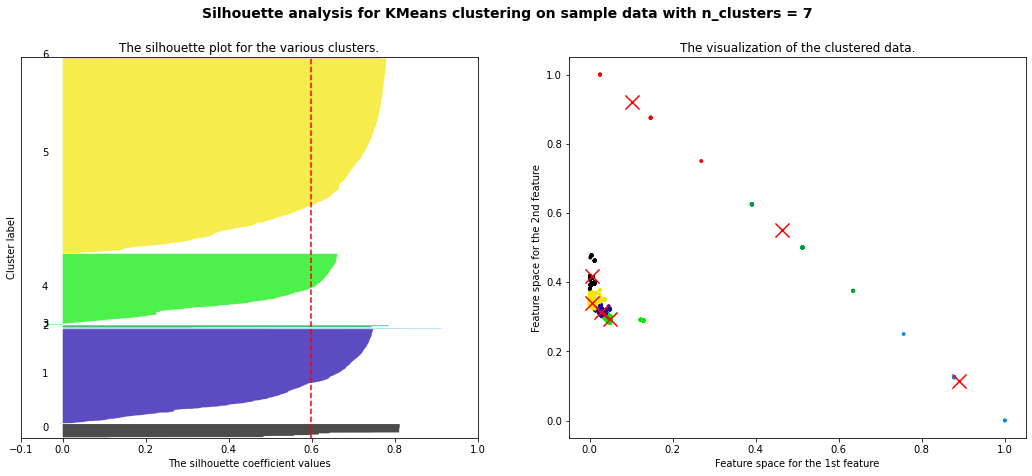

For n_clusters = 8 The average silhouette_score is : 0.5996612020554373


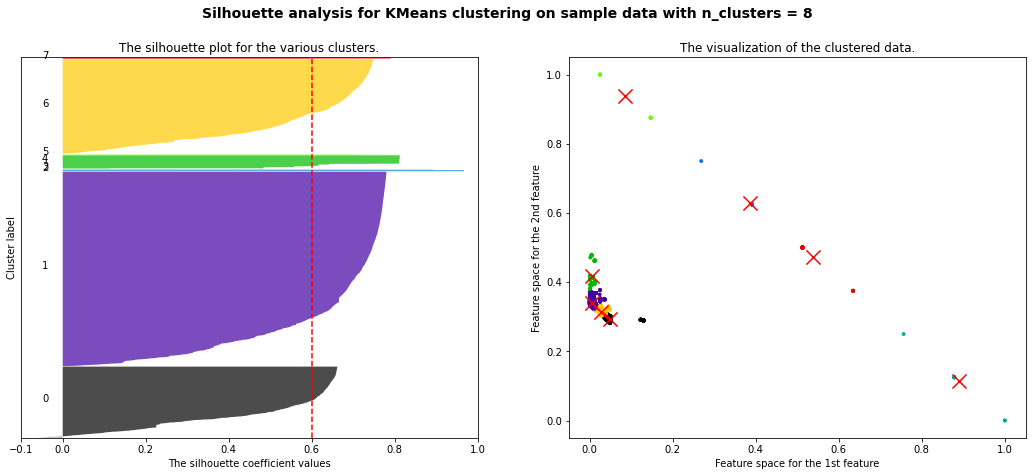

For n_clusters = 9 The average silhouette_score is : 0.6158204405544178


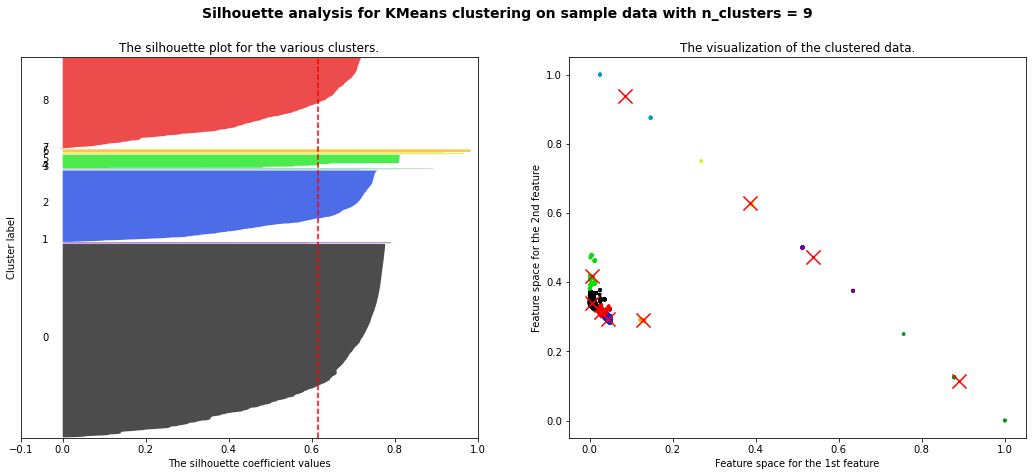

For n_clusters = 10 The average silhouette_score is : 0.5269166489586474


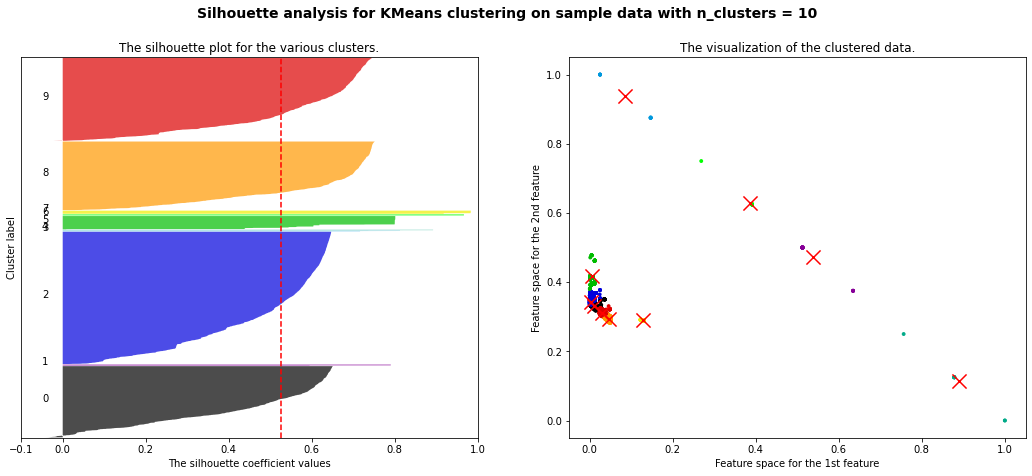

For n_clusters = 11 The average silhouette_score is : 0.5176499384142267


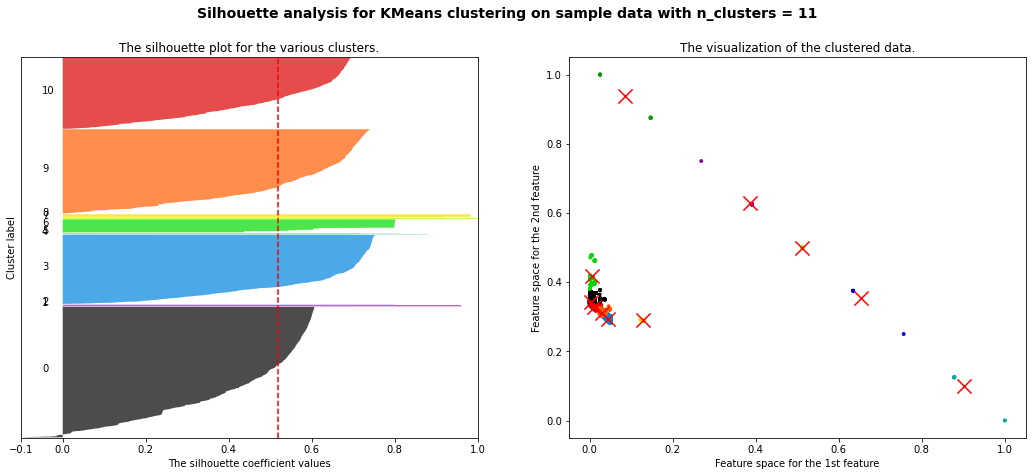

For n_clusters = 12 The average silhouette_score is : 0.5307740571727833


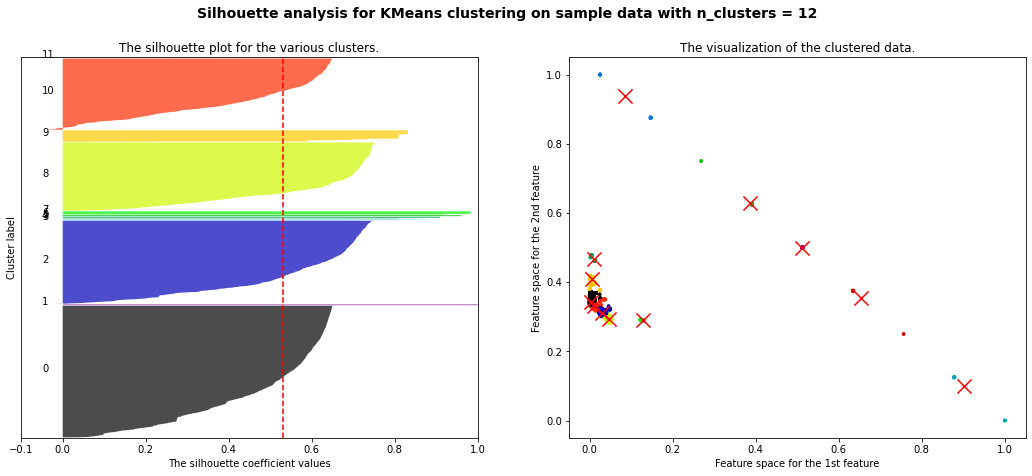

For n_clusters = 13 The average silhouette_score is : 0.5348891532583372


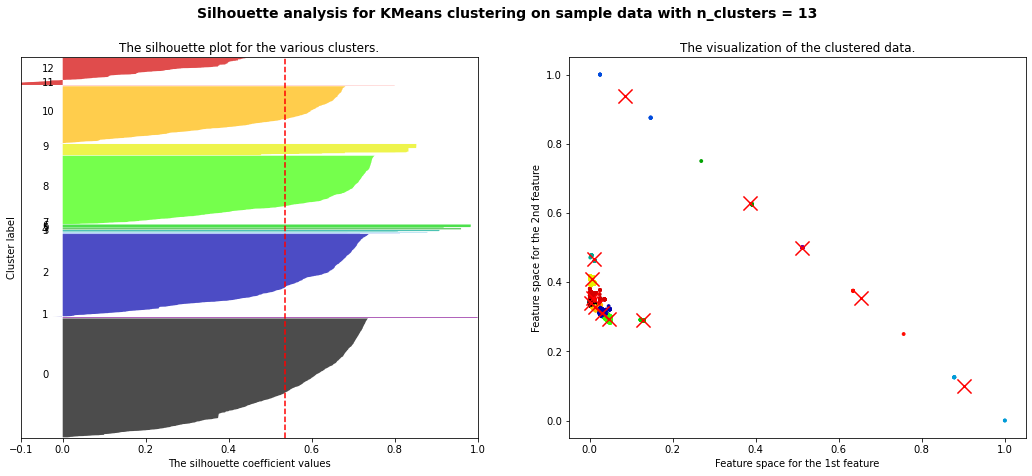

For n_clusters = 14 The average silhouette_score is : 0.5351458340824947


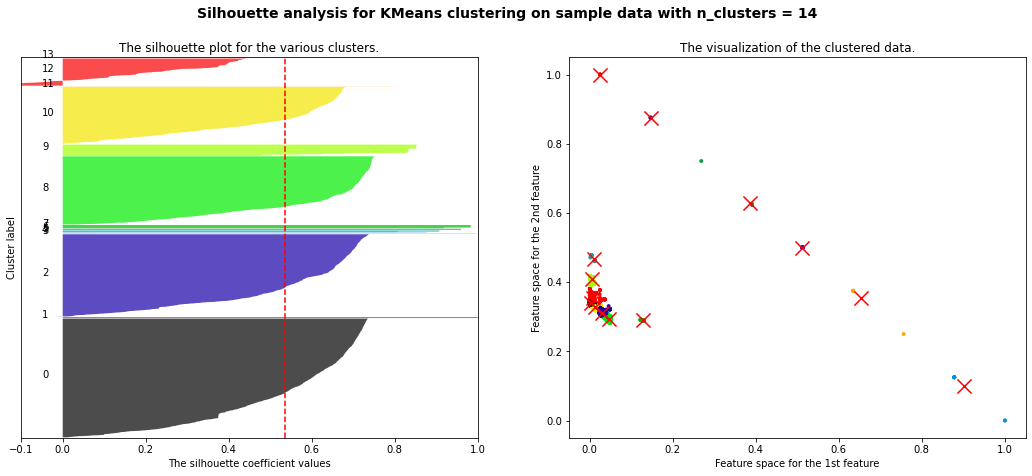

For n_clusters = 15 The average silhouette_score is : 0.4988279842547066


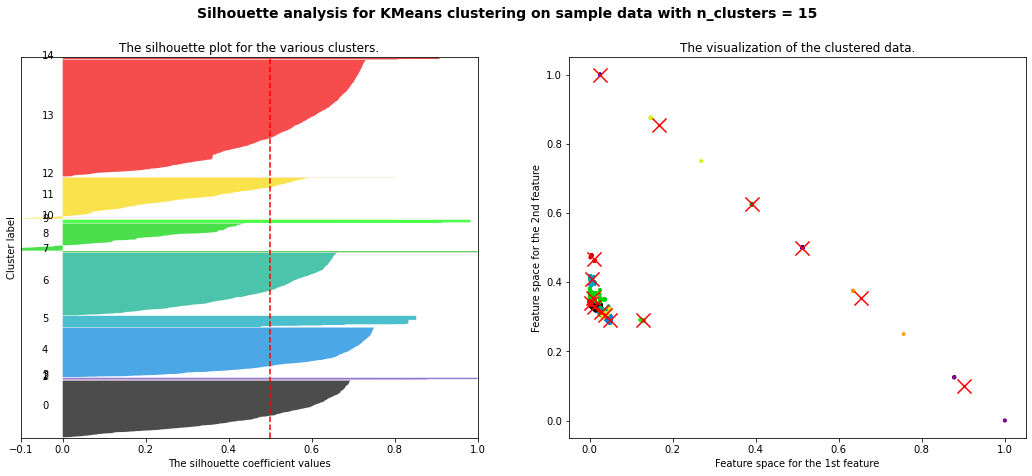

For n_clusters = 16 The average silhouette_score is : 0.5108413546685472


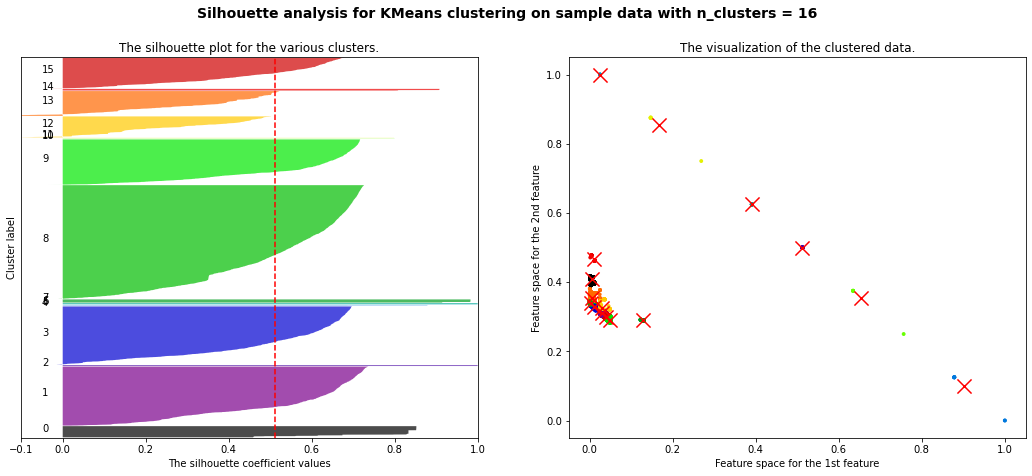

For n_clusters = 17 The average silhouette_score is : 0.5010780151211912


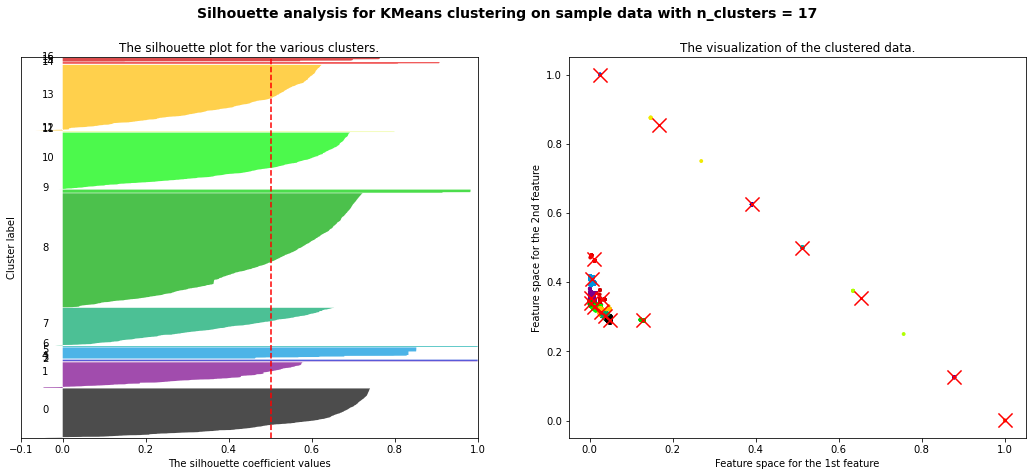

For n_clusters = 18 The average silhouette_score is : 0.4983398261341502


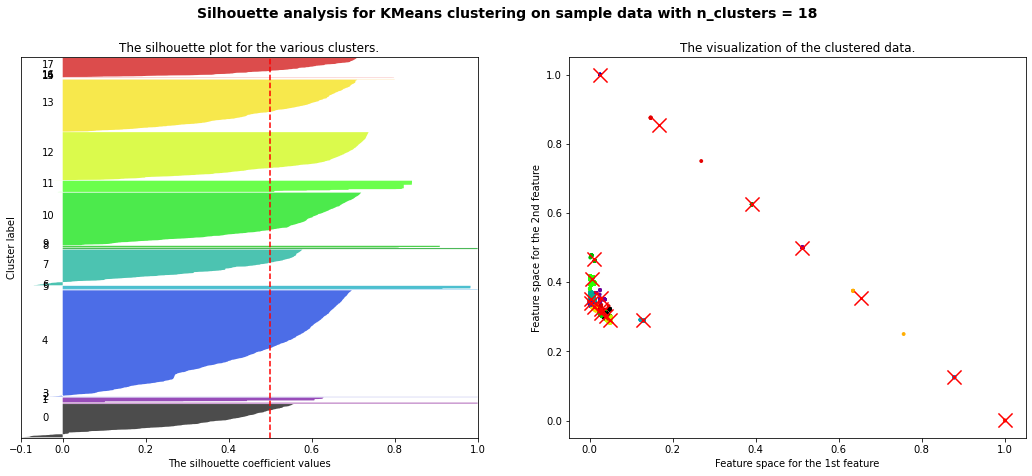

For n_clusters = 19 The average silhouette_score is : 0.5245665358750368


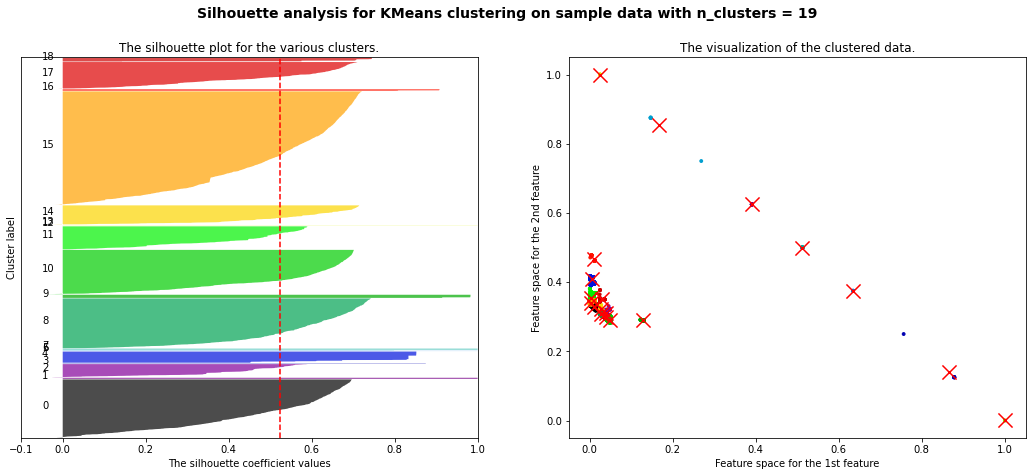

In [101]:
for n_clusters in range(2,20):
    n_clusters = n_clusters
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, X.shape[0] + (n_clusters + 1) * 10])
    clusterer = KMeans(n_clusters=n_clusters, random_state=10).fit(X)
    cluster_labels = clusterer.labels_
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)
    sample_silhouette_values = silhouette_samples(X, cluster_labels)
    y_lower = 10
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        color = cm.nipy_spectral(float(i)/n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper)
                          ,ith_cluster_silhouette_values
                          ,facecolor=color
                          ,alpha=0.7
                         )
        ax1.text(-0.05
                 , y_lower + 0.5 * size_cluster_i
                 , str(i))
        y_lower = y_upper + 10

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
    ax1.set_yticks([])
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1]
                ,marker='o'
                ,s=8
                ,c=colors
               )
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='x',
                c="red", alpha=1, s=200)
    
    
    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')
    plt.show()

###After using PCA model, the best n_clusters = 6 The average silhouette_score is : 0.5986641304898696

In [102]:
random = KMeans(n_clusters = 6).fit(X)

In [103]:
y_pred = random.labels_

In [104]:
result=pd.DataFrame({"UNITID":data_id,"result":y_pred})

In [105]:
result

,UNITID,result
0,100654,4
1,100663,4
2,100690,0
3,100706,4
4,100724,4
...,...,...
7799,48285703,4
7800,48285704,4
7801,48285705,4
7802,48285706,4


In [106]:
result.to_excel("result2.xlsx")

###Using PCA did not lead to a significant improvement in results, so we choose result.slsx. The purpose to use PCA is to reduce dimensions